# Milestone 2

In [4]:
import pandas as pd
import numpy as np
import bz2
import json

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Preprocessing data
Done on Google Collab since the raw Quotebank files are very large.
Collab notebook here: https://colab.research.google.com/drive/1nyBXU7oDZTowUuKzNX6UgzcoT-mN37r4#scrollTo=0y9u_2a6cvGa

## Load processed quotebank data

In [2]:
# read the large compressed file in 1 go 
path_to_quotes = './data/quotes-2020-speaker.json.bz2'
df_quotes = pd.read_json(path_to_quotes, lines=True, compression='bz2')
df_quotes = df_quotes.set_index('qid') #Change and rename index for future merging
df_quotes.index.rename('id', inplace=True)

In [3]:
df_quotes.head(5)

,quoteID,quotation,speaker,prob
id,,,,
Q367796,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,0.8867
Q20684375,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,0.5446
Q5268447,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,0.9240
Q4864119,2020-04-02-000239,[ The scheme ] treats addiction as an illness ...,Barry Coppinger,0.9017
Q816459,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,0.9227


## Load speaker data

In [5]:
#Load speaker attributes parquet file
path_to_attrib = './data/speaker_attributes.parquet'
df_attrib = pd.read_parquet(path_to_attrib)

#Load QID correspondance file and remove description column
path_to_labels = './data/wikidata_labels_descriptions_quotebank.csv.bz2'
df_labels = pd.read_csv(path_to_labels, compression='bz2', index_col = 'QID')
df_labels = df_labels.drop(['Description'], axis=1)

In [6]:
df_attrib.count()

aliases               1203402
date_of_birth         5017333
nationality           3715852
gender                7105600
lastrevid             9055981
ethnic_group           130385
US_congress_bio_ID      12874
occupation            6373084
party                  399176
academic_degree         99995
id                    9055981
label                 8543681
candidacy               65442
type                  9055981
religion               196284
dtype: int64

In [7]:
df_attrib.drop(columns=['aliases','US_congress_bio_ID','type','lastrevid','candidacy','label'],inplace=True)

In [8]:
# NOTE: takes too long to run on all labels, it is therefore not currently used
# Can run separately afterwards
def get_qid_label(df, dflabels):
    '''
    Replaces Wikidata Qids with the corresponding text
    :param df: dataframe to modify
    :param dflabels: 
    :return: the updated dataframe with text instead of qids
    '''
    for col in df.columns:
        try:
            df.loc[:, col] = df.loc[:, col].apply(lambda x: [dflabels.loc[cat].item() for cat in x] if x is not None else x)
        except:
            continue

    return df

## Merge files

In [10]:
#Merge quotes file and speaker attributes file based on the unique qid of the speaker
df_merged = df_quotes.merge(df_attrib.set_index('id'), left_index=True, right_index=True)
df_merged.head(5)

,quoteID,quotation,speaker,prob,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion
id,,,,,,,,,,,,
Q1000053,2020-01-30-115748,We stress that any attempts to fuel the confli...,Vasily Nebenzya,0.9429,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None
Q1000053,2020-01-30-110614,We consistently send signals to abandon aggres...,Vasily Nebenzya,0.5209,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None
Q1000053,2020-02-26-086429,We understand the concerns of a number of non-...,Vasily Nebenzya,0.9361,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None
Q1000053,2020-02-25-076403,"We cannot agree to that kind of approach,",Vasily Nebenzya,0.9680,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None
Q1000053,2020-01-09-098083,violation and noncompliance of international law.,Vasily Nebenzya,0.9364,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None


In [11]:
print(df_quotes.shape)
print(df_merged.shape)

(2511905, 4)
(2498965, 12)


We can see that after merged the 2 dataframes the size is reduced. This means that some unique speakers in the quotes dataframe do not correspond to any of the provided Wikidata entries.

## Getting lexical features

In [12]:
# creating dictonary that maps each pronoun to the correct category
pronouns = {
    'me' :'self',
    'myself' : 'self',
    'ours' : 'union',
    'ourselves' : 'union',
    'us' : 'union',
    'hers' : 'other',
    'herself' : 'other',
    'him' : 'other',
    'himself' : 'other',
    'hisself' : 'other',
    'one' : 'other',
    'oneself' : 'other',
    'she' : 'other',
    'thee' : 'other',
    'theirs' : 'other',
    'them' : 'other',
    'themselves' : 'other',
    'they' : 'other',
    'thou' : 'other',
    'thy' : 'other',
    'mine' : 'self',
    'my' : 'self',
    'our' : 'union',
    'ours' : 'union',
    'her' : 'other',
    'his' : 'other',
    'their' : 'other',
    'they' : 'other', 
    'your' : 'other',
    'we' : 'union',
    'i': 'self',
    'he': 'other',
    'she': 'other',
    'you': 'other',
    'yourself': 'other'
    }

In [13]:
sid = SentimentIntensityAnalyzer()

def add_sentiment_cols(row):
    '''
    Adds the sentiment column to the row.
    This column is based on NLTK's polarity score
    -1 one means 100 % negative, 1 100 % positive
    :param row: dataframe row to add column to
    :return: row with specified column added
    '''
    sentiments = sid.polarity_scores(row['quotation'])
    row['sentiment'] = sentiments['pos'] - sentiments['neg']
    return row

def add_morphological_cols(row):
    '''
    Adds the following columns to each row:

    self: count of pronouns referring to the speaker (ex: me, I)
    union: count of pronouns referring to the speaker and its group (ex: we, our)
    other: count of pronouns referring to someone else than the speaker (ex: he, their)
    adj_count: count of adjectives in the quote
    adj_ratio: ratio of regular adjectives in comparison to superlatives and comparatives

    -1 means only comparatives and superlatives, 1 only regular adjectives
    :param row: dataframe row to add columns to
    :return: row with specified columns added
    '''
    word_tag_pairs = nltk.pos_tag(nltk.word_tokenize(row['quotation']))
    adj_count = 0
    regular_adj_count = 0

    non_existing_keys = []

    # Count necessary tags in the quote of the row
    for word, tag in word_tag_pairs:
        if tag == 'PRP' or tag == 'PRPS':
            word_lower_case = word.lower()
            if word_lower_case in pronouns:
                row[pronouns[word_lower_case]] += 1
        elif tag[:2] == 'JJ':
            adj_count += 1
            if tag == 'JJ':
                regular_adj_count += 1
    row['adj_count'] = adj_count
    if adj_count == 0:
        row['adj_ratio'] = 0
    else:
        row['adj_ratio'] = 2 * ((regular_adj_count / adj_count) - (1 / 2))

    return row

def create_dataframe_with_features(df):
    '''
    Adds the following features to the dataframe:
    
    self: count of pronouns referring to the speaker (ex: I, my)
    union: count of pronouns referring to the speaker and its group (ex: we, our)
    other: count of pronouns referring to someone else than the speaker (ex: he, her)
    adj_count: count of adjectives in the quote
    adj_ratio: ratio of regular adjectives in comparison to superlatives and comparatives
    -1 means only comparatives and superlatives, 1 only regular adjectives
    sentiment: based on NLTK's polarity score, -1 one means 100 % negative, 1 100 % positive
    
    :param row: dataframe row to add columns to
    :return: row with specified columns added
    :param df: dataframe to add features to
    :return new_df: new dataframe with added features
    '''
    int_cols = ['self', 'union', 'other', 'adj_count']
    float_cols = ['adj_ratio', 'sentiment']
    new_df = df.copy()

    for col in int_cols:
        new_df[col] = 0

    new_df = new_df.apply(add_morphological_cols, axis = 1)
    new_df = new_df.apply(add_sentiment_cols, axis = 1)

    # making the size of the dataframe smaller by setting integers with clear upperbount to unsigned int8
    for col in float_cols:
        new_df[col] = new_df[col].astype('float16')
    for col in int_cols:
        new_df[col] = new_df[col].astype('int8')

    return new_df

In [14]:
df_merged.shape

(2498965, 12)

In [17]:
df_all_features = create_dataframe_with_features(df_merged)
df_all_features.head(10)

,quoteID,quotation,speaker,prob,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,religion,self,union,other,adj_count,adj_ratio,sentiment
id,,,,,,,,,,,,,,,,,,
Q1000053,2020-01-30-115748,We stress that any attempts to fuel the confli...,Vasily Nebenzya,0.9429,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,1,0,1,1.000000,-0.367920
Q1000053,2020-01-30-110614,We consistently send signals to abandon aggres...,Vasily Nebenzya,0.5209,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,1,0,5,0.600098,0.024002
Q1000053,2020-02-26-086429,We understand the concerns of a number of non-...,Vasily Nebenzya,0.9361,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,1,0,3,1.000000,0.064026
Q1000053,2020-02-25-076403,"We cannot agree to that kind of approach,",Vasily Nebenzya,0.9680,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,1,0,0,0.000000,-0.232056
Q1000053,2020-01-09-098083,violation and noncompliance of international law.,Vasily Nebenzya,0.9364,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,0,0,1,1.000000,-0.389893
Q1000053,2020-01-28-105408,"We were not consulted, we don't know what this...",Vasily Nebenzya,0.9512,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,2,0,0,0.000000,0.000000
Q1000053,2020-02-11-012952,But what if one side-Palestine-considers the p...,Vasily Nebenzya,0.8329,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,0,0,6,1.000000,0.096008
Q1000053,2020-02-28-048691,not to bury Astana process,Vasily Nebenzya,0.5201,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,0,0,0,0.000000,0.000000
Q1000053,2020-01-30-075841,Russia has no hidden agenda in the Libyan conf...,Vasily Nebenzya,0.8704,[+1962-02-26T00:00:00Z],"[Q159, Q15180]",[Q6581097],None,"[Q193391, Q82955]",None,None,None,0,0,0,1,1.000000,-0.391113


In [45]:
file_path = './generated/quotes-2020-with-features.json.bz2'
df_to_json = df_all_features.set_index('quoteID')
df_to_json.to_json(file_path, compression = 'bz2')

## Plotting some distributions

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
%matplotlib inline

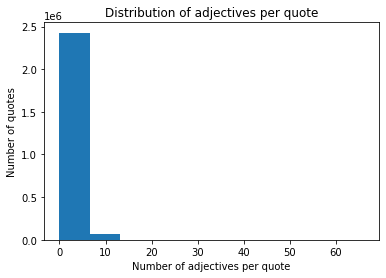

In [44]:
histogram = df_all_features['adj_count'].hist()
histogram.set_title("Distribution of adjectives per quote")
histogram.set_ylabel("Number of quotes")
histogram.set_xlabel("Number of adjectives per quote")
histogram.grid(False)

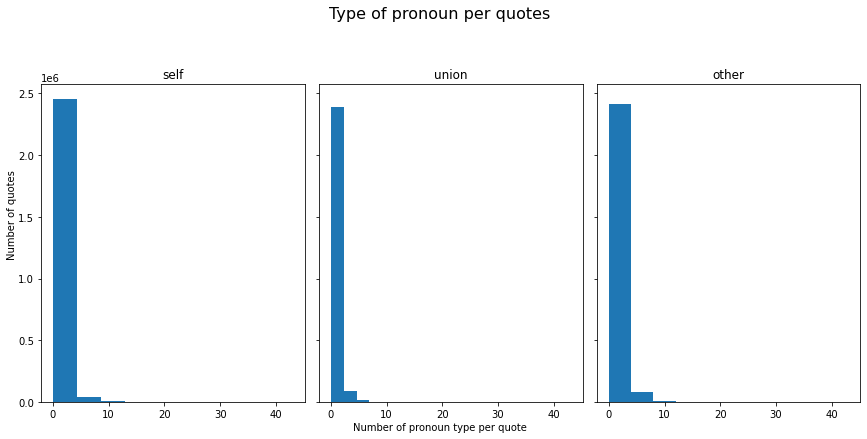

In [42]:
fig, ax = plt.subplots(1,3,figsize= (12,6), sharey = True, sharex = True)

columns = ['self','union','other']
for idx, col in enumerate(columns):
    ax[idx].hist(df_all_features[col])
    ax[idx].set_title(col)

fig.tight_layout()
fig.text(0.4,0, "Number of pronoun type per quote")
fig.text(0,0.4, "Number of quotes", rotation = 90)

ax[0].xaxis.set_major_formatter(ticker.EngFormatter())
fig.suptitle("Type of pronoun per quotes", fontsize = 16)
plt.subplots_adjust(top=0.80)